In this section we will provide the results from four modeling approaches.  Three of these 
modeling approaches are defined for you, and you get to choose the fourth approach from the 
list of choices.   
    - For each model provide any relevant or useful model output and a table of the model
    performance in-sample (i.e. on the training data set) and out-of-sample (i.e. on the test data set).   
    - The metrics to be measured are:   
        (1) true positive rate or sensitivity  
        (2) false positive rate  
        (3) the accuracy.  
 
5.a Random Forest  
    - Include the variable importance plot.  
 
5.b Gradient Boosting  
    - Use GBM or XGBoost packages.  Include the variable importance plot.  

5.c Logistic Regression with Variable Selection   
    - Random Forest and Gradient Boosting will identify a pool of interesting predictor 
    variables.  Use that information to help you choose an initial pool of predictor variables.   
    List your initial pool of predictor variables in a table.   
    - Choose a variable selection algorithm.  Use that variable selection algorithm to arrive at 
    an ‘optimal’ logistic regression model.  
    - Since this is a linear model, you should provide a table of the model coefficients and 
    their p-values.  
 
5.d Your Choice – CHAID, Neural Network, SVM, or some other method appropriate for 
binary classification.   
    - Provide the relevant output for the model of choice.  For example SVM has margin 
    plots that are useful, and a neural network allows you to plot out the network topology.  If 
    your chosen method has a ‘standard’ plot that is typically shown with it, then we all 
    expect to see that plot, and you should be providing that plot with the model.

In [1]:
### ref https://blog.jovian.ai/machine-learning-with-python-implementing-xgboost-and-random-forest-fd51fa4f9f4c#b9a9
# !pip install numpy pandas matplotlib seaborn --quiet
# !pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet
# !pip install pyreadr

#importing dataset
import os
# import opendatasets as od
import pandas as pd
import numpy as np
import pyreadr

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [2]:
credit_card_default_raw = pd.read_csv('./Data/credit_card_default.csv')
# credit_card_default_eng = pd.read_csv('./Data/credit_card_default_eng.csv')
result = pyreadr.read_r('./Data/credit_card_default_eng_features.RData') 
credit_card_default_eng = result[None]

credit_card_default = credit_card_default_eng.copy()
df_flags = credit_card_default_raw[['data.group', 'DEFAULT']]
df_other_features = credit_card_default_raw[['SEX','EDUCATION','MARRIAGE','AGE']]
credit_card_default = credit_card_default.join(df_flags)
credit_card_default = credit_card_default.join(df_other_features)


In [3]:

display(credit_card_default.describe())
display(credit_card_default.head())

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT,SEX,EDUCATION,MARRIAGE,AGE
count,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,3.99390,44976.945200,5275.232094,0.576423,0.375468,-0.090664,6.057244e+04,1.584823e+04,0.682200,1.743900,0.221200,1.603733,1.853133,1.551867,35.485500
std,0.95845,63260.721860,10137.946323,16.499616,0.355618,0.279674,7.840481e+04,3.793356e+04,1.073518,0.830864,0.415062,0.489129,0.790349,0.521970,9.217904
min,3.00000,-56043.166667,0.000000,0.000000,-0.232590,-4.700400,-6.029000e+03,0.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,21.000000
25%,3.00000,4781.333333,1113.291667,0.047855,0.028925,-0.146863,1.006000e+04,2.198000e+03,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,28.000000
50%,4.00000,21051.833333,2397.166667,0.197668,0.286554,-0.004382,3.120850e+04,5.000000e+03,0.000000,1.000000,0.000000,2.000000,2.000000,2.000000,34.000000
75%,5.00000,57104.416667,5583.916667,0.903817,0.692718,0.028105,7.959900e+04,1.210000e+04,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,41.000000
max,8.00000,877313.833333,627344.333333,2667.199955,5.537758,1.791100,1.664089e+06,1.684259e+06,8.000000,3.000000,1.000000,2.000000,6.000000,3.000000,79.000000


,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT,SEX,EDUCATION,MARRIAGE,AGE
0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0,1,1,2,2,1,24
1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0,3,1,2,2,2,26
2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0,1,0,2,2,2,34
3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0,3,0,2,2,1,37
4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0,3,0,1,2,1,57


In [4]:
credit_card_default.dtypes

age_bins              float64
bill_avg              float64
payment_avg           float64
ratio_avg             float64
util_avg              float64
balance_growth_6mo    float64
bill_max              float64
payment_max           float64
pay_max               float64
data.group              int64
DEFAULT                 int64
SEX                     int64
EDUCATION               int64
MARRIAGE                int64
AGE                     int64
dtype: object

In [5]:
ccd_train = credit_card_default[credit_card_default['data.group']==1].drop(columns='data.group')
ccd_test = credit_card_default[credit_card_default['data.group']==2].drop(columns='data.group')
ccd_validate = credit_card_default[credit_card_default['data.group']==3].drop(columns='data.group')

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (15180, 14)
test data size: (7323, 14)
validate data size: (7497, 14)


In [6]:
X = credit_card_default.drop(columns='data.group')
X_train = ccd_train.drop(columns='DEFAULT')
X_train_official = ccd_train.drop(columns='DEFAULT') # _official is for k_fold or other resplitting methods that would change defn
X_test = ccd_test.drop(columns='DEFAULT')
X_test_official = ccd_test.drop(columns='DEFAULT')

y = credit_card_default['DEFAULT']
y_train = ccd_train['DEFAULT']
y_train_official = ccd_train['DEFAULT']
y_test = ccd_test['DEFAULT']
y_test_official = ccd_test['DEFAULT']

Prep for modeling

In [7]:
all_features = credit_card_default_eng.columns
all_features = all_features.tolist()

In [8]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['age_bins',
 'bill_avg',
 'payment_avg',
 'ratio_avg',
 'util_avg',
 'balance_growth_6mo',
 'bill_max',
 'payment_max',
 'pay_max',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE']

[]

In [9]:
### we've done our own splitting

# #import train_test_split library
# from sklearn.model_selection import train_test_split

# # create train test split
# y_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42) 

In [10]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [11]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )

5.a Model  
ref: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python

In [12]:
from sklearn import svm
clf = svm.SVC(kernel='linear') # Linear Kernel


In [13]:
%timeit
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [14]:

y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))
# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.7700396012563158
Precision: 0.39434276206322794
Recall: 0.15221579961464354


,precision,recall,f1-score,support
0,0.80,0.94,0.87,5766.00
1,0.39,0.15,0.22,1557.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.60,0.54,0.54,7323.00
weighted avg,0.72,0.77,0.73,7323.00


[[5402  364]
 [1320  237]]


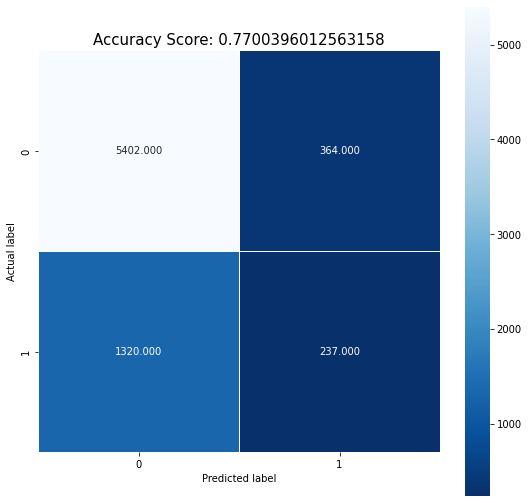

In [15]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


In [16]:
X = X_train.copy()
y_train.copy()
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.subplot(2, 2, i + 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title(titles[i])


InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
# Generate scatter plot for training data 
plt.scatter(X_train[:,0], X_train[:,1])
plt.title('Linearly separable data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


# Get support vector indices
support_vector_indices = clf.support_
print(support_vector_indices)

# Get number of support vectors per class
support_vectors_per_class = clf.n_support_
print(support_vectors_per_class)

# Get support vectors themselves
support_vectors = clf.support_vectors_

# Visualize support vectors
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

InvalidIndexError: (slice(None, None, None), 0)

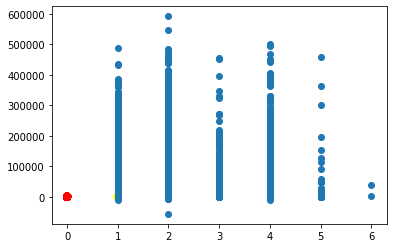

In [ ]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')
plt.scatter(clf.support_vectors_[:,0],clf.support_vectors_[:,1])
plt.show()


ValueError: 'c' argument has 30000 elements, which is inconsistent with 'x' and 'y' with size 15180.

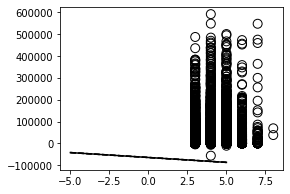

In [18]:
# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(4, 3))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10, edgecolors='k')
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
            edgecolors='k')

plt.axis('tight')
x_min = -4.8
x_max = 4.2
y_min = -6
y_max = 6

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[X, y])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(figsize=(4, 3))
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())

plt.show()